In [6]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia  #cancer imaging archive
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
import json 

In [7]:
datadir= "C:\.Projects\Medical_storage\Data"

Part 1 --> Open CT Image 

In [8]:
cartname= "nbia-94941702869768263"
cartdata= nbia.getSharedCart(cartname)
df= nbia.downloadSeries(cartdata, format="df", path=datadir)

2023-12-18 01:33:54,294:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-94941702869768263'}
2023-12-18 01:33:55,742:INFO:Downloading 2 Series Instance UIDs (scans).
2023-12-18 01:33:57,263:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.147727698049157996140705051331 already downloaded.
2023-12-18 01:33:58,623:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2023-12-18 01:33:58,623:INFO:Downloaded 0 out of 2 Series Instance UIDs (scans).
0 failed to download.
2 previously downloaded.


In [9]:
CTfolder= os.path.join(datadir, "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668")

Open data in Pydicom


In [10]:
ds =pydicom.read_file(os.path.join(CTfolder, "1-367.dcm"))

In [11]:
#obtain pixel data w pixe_array 
image=ds.pixel_array
image.shape

(512, 512)

In [12]:
#convert units
image=ds.RescaleSlope*image + ds.RescaleIntercept

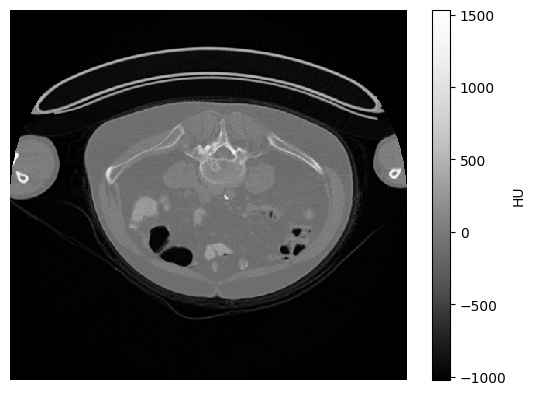

In [13]:
#show the image
plt.pcolormesh(image, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis("off")
plt.show()

open data using Monai

In [14]:
image_loader=LoadImage(image_only=True)
CT= image_loader(CTfolder)

In [15]:
CT.meta 

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

In [16]:
CT_coronal=CT[:,220].cpu().numpy()

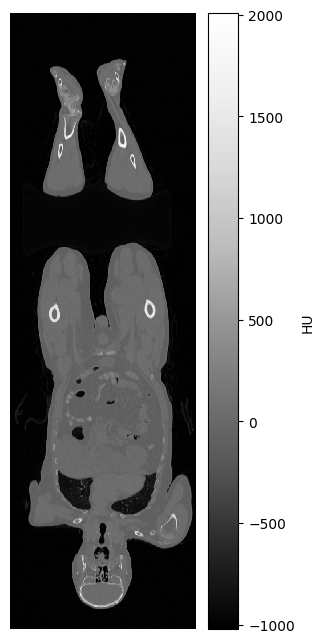

In [17]:
#view image
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal.T, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis("off")
plt.show()

In [18]:
CT.shape


torch.Size([512, 512, 975])

In [19]:
#transform 
channeltransf=EnsureChannelFirst()
CT=channeltransf(CT)
CT.shape

torch.Size([1, 512, 512, 975])

In [20]:
#reorient image
orientransf=Orientation(axcodes=("LPS"))
CT= orientransf(CT)

In [21]:
CT_coronal= CT[0,:,256].cpu().numpy()

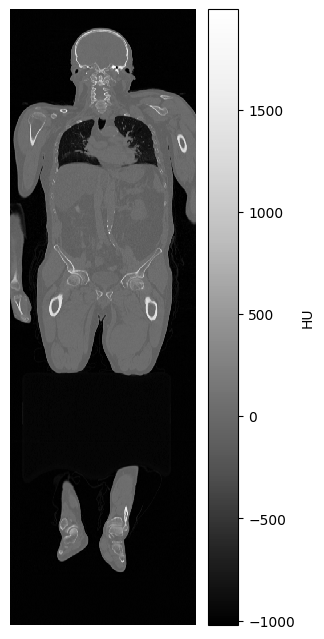

In [22]:
#view image
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal.T, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis("off")
plt.show()

In [23]:
#combine all the transforms in 1 image
preproc_pipeline= Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes="LPS")
])

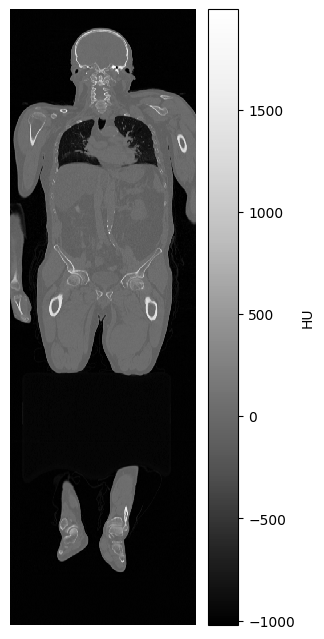

In [24]:
#open pipeline
CT=preproc_pipeline(CTfolder)
CT_coronal= CT[0,:,256].cpu().numpy()

plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal.T, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis("off")
plt.show()

Part 2 --> Segmentation model 

In [25]:
modelpath=os.path.join(datadir, "wb_ctsegm", "models", "model_lowres.pt" )
configpath=os.path.join(datadir, "wb_ctsegm", "configs", "inference.json")

In [26]:
config=ConfigParser()
config.read_config(configpath)

In [27]:
#preprocessing pipeline
preprocessing=config.get_parsed_content("preprocessing")


In [43]:
data = {'image': CT}


In [50]:
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

Model


In [ ]:
model= config.get_parsed_content("network")

In [45]:
model.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))
model.eval();

Inferer


In [46]:
inferer= config.get_parsed_content("inferer")

Postprocessing

In [47]:
postprocessing=config.get_parsed_content("postprocessing")

In [52]:
data['image'].shape

torch.Size([1, 512, 512, 975])

Prediction

In [ ]:
data = {'image': CT}
with torch.no_grad():
    data['pred']=inferer(data['image'].unsqueeze(0), network=model)




In [ ]:
data['pred']=data['pred'][0]
data['image']= data['image'][0]

In [ ]:
data=postprocessing(data)
segm= torch.flip(data['pred'][0], dims=[2])
segm= segm-cpu().numpy()

In [ ]:
segm.shape

In [ ]:
slice_idx= 250
CT_coronal= CT[0,:slice_idx].cpu().numpy()
segm_coronal=segm[:,slice_idx]

In [ ]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal.T, cmap="Greys_r")
plt.axis('off')
plt.subplt(122)
plt.pcolormesh(segm_coronal.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()